#Overview


* This notebook was created in colab and meant to interface with our team's GCP Bucket (mounts). Link to colab notebook [here](https://drive.google.com/file/d/1GmVixIsCiJLqACfepLAC9mO-gr-Q9-m_/view?usp=sharing).
* Milestone versions of this notebook are in [github](https://github.com/dyeramosu/ac215_snapnutrition)
* This notebook has 2 sections 1) data exploration and 2) model building
* This beginning notebook also helped us to figure out what data we need and what needs to be pre-processed.


# Nutrition5k Dataset EDA



## Nutrition5K Paper DataSource Overview

*   Nurtiion5k paper had their data in a GCP bucket. They have a Google Bucket link [here](https://console.cloud.google.com/storage/browser/nutrition5k_dataset;tab=objects?prefix=&forceOnObjectsSortingFiltering=false)
*   Bucket size total of 181 GB (includes photos and 360-degree surround food videos)
*   Nutrition5k is a medium dataset (less than 2TB). It will not fit in RAM but maybe in local disk
*   Nutrition5k papers did not attempt to identify the food in the images unlike FOODD. Instead it tried to use images at various angles and later depth images.


1) First we'll need to extract the unique ID for each dish image. We will also need the corresponding nutrition info of each food image. The following csv's contain all nutrition metadata at the dish_id-level, as well as per-ingredient mass and macronutrients. The default directory structure is:

```
  └── nutrition5k_dataset
        └──metadata
           ├── dish_metadata_cafe1.csv
           └── dish_metadata_cafe2.csv
```
For each dish ID dish_[10 digit timestamp], there is a CSV entry containing the following fields:

```
dish_id, total_calories, total_mass, total_fat, total_carb, total_protein, num_ingrs,
(ingr_1_id, ingr_1_name, ingr_1_grams, ingr_1_calories, ingr_1_fat, ingr_1_carb, ingr_1_protein, ...)
with the last 8 fields are repeated for every ingredient present in the dish.
```
Note: There is a seperate CSV for each ingredient ID and their nutrition info at:

```
nutrition5k_dataset/nutrition5k_dataset/metadata/ingredients_metadata.csv
```

2) Second we'll need to extract the overhead shot of each image using dish_id. We will ognore the depth shots for each dish_id for now. The default directory structure we will look into is:

```
  └── nutrition5k_dataset
        └──imagery
            └── realsense_overhead
                 ├──dish_{ID}
                 │   ├── depth_color.png
                 │   ├── depth_raw.png
                 │   └── rbg.png
                 ├──dish_{ID}...
                 ...                  
```



## Mount Team SnapNutrition GCP Bucket To Colab

Instead of reading files directly from Nutrion5k's GCP bucket, we transferred a subset of the files of interest (excluding video files) into our own bucket for versioning.

From now on we will use our GCP bucket data source [direct link](https://console.cloud.google.com/storage/browser/snapnutrition_data_bucket?authuser=0&project=csci-115-398800&pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false)

In [1]:
#cell to connect to our GCP Bucket
from google.colab import auth

auth.authenticate_user()

#THIS WILL CREATE A GOOGLE POP-UP WINDOW TO LOGIN
#If you do not have access to our bucket, please message brent ruttle

In [2]:
!gcloud config set project csci-115-398800

Updated property [core/project].


Install package needed to mount GCP Bucket to colab

In [3]:
!echo "deb https://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  29979      0 --:--:-- --:--:-- --:--:-- 30215
OK
27 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-bionic/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Failed to fetch https://cloud.r-project.org/bin/linux/ubuntu/jammy-cran40/InRelease  Could not resolve 'cloud.r-project.org'
W: Some index files failed to download. They have been ignored, or old ones used instead.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 5,558 kB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading

Make a directory and mount GCP bucket "snapnutrition_data_bucket" to the folder

In [4]:
!mkdir snapnutrition_data_bucket
!gcsfuse --implicit-dirs snapnutrition_data_bucket snapnutrition_data_bucket
!gcsfuse --implicit-dirs snapnutrition_data_bucket/data/tf_records snapnutrition_data_bucket/data/tf_records

#!chmod 777 -R snap_nutrition_data

{"time":"27/10/2023 03:36:09.352099","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /content/snapnutrition_data_bucket\n"}
{"time":"27/10/2023 03:36:09.957568","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /content/snapnutrition_data_bucket/data/tf_records\n"}
daemonize.Run: readFromProcess: sub-process: mountWithArgs: mountWithStorageHandle: fs.NewServer: create file system: SetUpBucket: Error in iterating through objects: storage: bucket doesn't exist


In [5]:
!pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 4.0 MB/s eta 0:00:00


In [6]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


##Exploratory Data Analysis (EDA)

In [7]:
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import time
import subprocess
from glob import glob


# sklearn
from sklearn.model_selection import train_test_split

import requests
import tempfile
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
import random
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# TF Hub
import tensorflow_hub as hub

# TF Optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude

# W&B
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger

AUTOTUNE = tf.data.AUTOTUNE
#constants for using the Nutrition5k Research Paper's Public Google Bucket
GOOGLE_BUCKET_DOMAIN = "https://storage.googleapis.com/"
DISH_IMAGES_DIRECTORY = "nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/"
#TFRECORDS_DIRECTORY = "snapnutrition_data_bucket/data/tf_records/180_by_180"
#TFRECORDS_DIRECTORY = "snapnutrition_data_bucket/data/tf_records/180_by_180_dask_normalized"
TFRECORDS_DIRECTORY = "snapnutrition_data_bucket/data/tf_records/224_by_224_dask_normalized"

In [8]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
#print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set the global random seed
tf.random.set_seed(215)
np.random.seed(215)
random.seed(215)

tensorflow version 2.14.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
!nvidia-smi

Fri Oct 27 15:36:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    47W / 400W |    679MiB / 40960MiB |      1%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
# paths to read train test val data (has image filepaths and corresponding labels
TEST_SAVE_PATH = "./snapnutrition_data_bucket/data/processed_labels/test_data.pickle"

# read train, test, validation data from pickle files
test_xy = pd.read_pickle(TEST_SAVE_PATH)

len(test_xy)

489

In [11]:
actual_calories = []
actual_mass = []
actual_fat = []
actual_carb = []
actual_protein = []
y_test  = []

for i, element in enumerate(test_xy):
  actual_calories.append(float(element[0][0]))
  actual_mass.append(float(element[0][1]))
  actual_fat.append(float(element[0][2]))
  actual_carb.append(float(element[0][3]))
  actual_protein.append(float(element[0][4]))
  y_test.append([float(element[0][0]),float(element[0][1]), float(element[0][2]), float(element[0][3]), float(element[0][4])])

In [12]:
def compare_model_sizes(model):
  _, model_file = tempfile.mkstemp(".h5")
  tf.keras.models.save_model(model, model_file, include_optimizer=False)
  # Zip the .h5 model file
  _, zip3 = tempfile.mkstemp(".zip")
  with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
      f.write(model_file)
  model_before_zip = os.path.getsize(model_file) / float(1000)
  model_after_zip = os.path.getsize(zip3) / float(1000)
  print("Model before zip: %.2f Kb"% model_before_zip)
  print("Model after zip: %.2f Kb"% model_after_zip)
  return model_before_zip, model_after_zip

def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = "snapnutrition_data_bucket/compression_workspace/EfficientV2L_models"
def save_model(model,model_train_history,execution_time, learning_rate, epochs,
               optimizer, evaluation_results, before_zip_size, after_zip_size, inference_time):
              #  avg_calories_off, avg_mass_off, avg_fat_off, avg_carb_off, avg_protein_off, min_calories_off,
              #  min_mass_off, min_fat_off, min_carb_off, min_protein_off, max_calories_off, max_mass_off,
              #  max_fat_off, max_carb_off, max_protein_off):
  model_name=model.name

  # Ensure path exists
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)
  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

  model_size = get_model_size(model_name=model.name)

  # Save model history
  with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  trainable_parameters = count_params(model.trainable_weights)
  non_trainable_parameters = count_params(model.non_trainable_weights)

  # Save model metrics
  metrics ={
      "trainable_parameters":trainable_parameters,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      # "val_loss": evaluation_results[2],
      "root_mean_squared_error":evaluation_results[1],
      # "val_root_mean_squared_error": evaluation_results[3],
      "model_size":model_size,
      "learning_rate":learning_rate,
      "batch_size":batch_size,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__,
      "before_zip_size": before_zip_size,
      "after_zip_size": after_zip_size,
      "test_set_inference_time(min)": inference_time#,
      # "avg_calories_off":avg_calories_off,
      # "avg_mass_off": avg_mass_off,
      # "avg_fat_off": avg_fat_off,
      # "avg_carb_off": avg_carb_off,
      # "avg_protein_off": avg_protein_off,
      # "min_calories_off": min_calories_off,
      # "min_mass_off": min_mass_off,
      # "min_fat_off": min_fat_off,
      # "min_carb_off": min_carb_off,
      # "min_protein_off": min_protein_off,
      # "max_calories_off": max_calories_off,
      # "max_mass_off": max_mass_off,
      # "max_fat_off": max_fat_off,
      # "max_carb_off": max_carb_off,
      # "max_protein_off": max_protein_off
  }
  with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".hdf5")).st_size
  return model_size

def append_training_history(model_train_history, prev_model_train_history, metrics=["loss","val_loss","root_mean_squared_error","val_root_mean_squared_error"]):
  for metric in metrics:
    for metric_value in prev_model_train_history[metric]:
      model_train_history[metric].append(metric_value)

  return model_train_history


def evaluate_model(model,test_data, model_train_history,execution_time,
                        learning_rate, batch_size, epochs, optimizer,
                        save=True,
                        loss_metrics=["loss","val_loss"],
                        acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"], evaluation_metrics=None):

  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  axs = fig.add_subplot(1,2,2)
  axs.set_title('Root Mean Squared Error')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()

  # Evaluate on test data
  start_time = time.time()
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)
  inference_time = (time.time() - start_time)/60.0
  print("Inference execution time (mins)", inference_time)

  if not evaluation_metrics:
    # for distillation, want to pass previous distill results, not recreate them since will be extra col
    evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]
    #evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]], evaluation_results[loss_metrics[1]], evaluation_results[acc_metrics[1]]]
  else:
    evaluation_results = evaluation_metrics

  if save:
    # Save model

    # loss = keras.losses.MeanSquaredError()
    # #if evaluation_metrics:
    # model = model.compile(optimizer=optimizer,
    #                 loss=loss,
    #                 metrics=[keras.metrics.RootMeanSquaredError()])

    #should only see big differences if pruned and have 0 weights
    before_zip_size, after_zip_size = compare_model_sizes(model)

    # #let's just get the y_pred
    # full_test_predicted = model.predict(test_data)
    # full_test_results = {'actual_calories': actual_calories, 'pred_calories': full_test_predicted[:, 0], 'actual_mass': actual_mass, 'pred_mass':full_test_predicted[:, 1],
    #                     'actual_fat': actual_fat, 'pred_fat': full_test_predicted[:, 2], 'actual_carb': actual_carb, 'pred_carb': full_test_predicted[:, 3],'actual_protein': actual_protein, 'pred_protein':full_test_predicted[:,4]}
    # full_test_results_df = pd.DataFrame(data=full_test_results)
    # full_test_results_df['calorie_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_calories'] - x['pred_calories']), axis=1)
    # full_test_results_df['mass_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_mass'] - x['pred_mass']), axis=1)
    # full_test_results_df['fat_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_fat'] - x['pred_fat']), axis=1)
    # full_test_results_df['carb_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_carb'] - x['pred_carb']), axis=1)
    # full_test_results_df['protein_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_protein'] - x['pred_protein']), axis=1)
    # avg_calories_off =  full_test_results_df.loc[:, 'calorie_estimation_difference'].mean()
    # avg_mass_off = full_test_results_df.loc[:, 'mass_estimation_difference'].mean()
    # avg_fat_off = full_test_results_df.loc[:, 'fat_estimation_difference'].mean()
    # avg_carb_off = full_test_results_df.loc[:, 'carb_estimation_difference'].mean()
    # avg_protein_off = full_test_results_df.loc[:, 'protein_estimation_difference'].mean()
    # min_calories_off =  full_test_results_df.loc[:, 'calorie_estimation_difference'].min()
    # min_mass_off = full_test_results_df.loc[:, 'mass_estimation_difference'].min()
    # min_fat_off = full_test_results_df.loc[:, 'fat_estimation_difference'].min()
    # min_carb_off = full_test_results_df.loc[:, 'carb_estimation_difference'].min()
    # min_protein_off = full_test_results_df.loc[:, 'protein_estimation_difference'].min()
    # max_calories_off =  full_test_results_df.loc[:, 'calorie_estimation_difference'].max()
    # max_mass_off = full_test_results_df.loc[:, 'mass_estimation_difference'].max()
    # max_fat_off = full_test_results_df.loc[:, 'fat_estimation_difference'].max()
    # max_carb_off = full_test_results_df.loc[:, 'carb_estimation_difference'].max()
    # max_protein_off = full_test_results_df.loc[:, 'protein_estimation_difference'].max()

    # print("average calories off: ",  avg_calories_off)
    # print("average mass off (grams): ",  avg_mass_off)
    # print("average fat off (grams): ", avg_fat_off)
    # print("average carb off (grams): ", avg_carb_off)
    # print("average protein off (grams): ", avg_protein_off)

    save_model(model, model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results, before_zip_size, after_zip_size, inference_time)
    #, avg_calories_off, avg_mass_off, avg_fat_off, avg_carb_off, avg_protein_off, min_calories_off, min_mass_off, min_fat_off, min_carb_off, min_protein_off,  max_calories_off,  max_mass_off, max_fat_off, max_carb_off, max_protein_off)

  return evaluation_results

### Create TF Records

In [13]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
NUM_CHANNELS = 3


# Model Building

1. full_label_df connects unique dish_id's to the nutrition info
2. dish_id also corresponds to the image directory to get the regular png (we will exclude depth images for now)

**Model Input:** will be the overhead image png


**Model Output:** will be (total_calories, total_mass, total_fat, total_carb, total_protein)


Followed this tutorial for loading images via tensorflow https://www.tensorflow.org/tutorials/load_data/images

## Load TF Data from TFRecords

In [14]:
from IPython.testing import test
batch_size = 128

# Read TF Records
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([5], tf.float32, default_value=[0.0, 0.0, 0.0, 0.0, 0.0])
}

# @tf.function
def parse_tfrecord_example(example_proto):
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  #image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.float32)
  image.set_shape([IMAGE_WIDTH * IMAGE_HEIGHT * NUM_CHANNELS])
  image = tf.reshape(image, [IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS])
  # Label
  label = parsed_example['label']

  return image, label

# # Normalize pixels
# def normalize(image, label):
#   image = image/255
#   return image, label

# Read the tfrecord files
train_tfrecord_files = tf.data.Dataset.list_files(TFRECORDS_DIRECTORY+'/train*')
validate_tfrecord_files = tf.data.Dataset.list_files(TFRECORDS_DIRECTORY+'/val*')
test_tfrecord_files = tf.data.Dataset.list_files(TFRECORDS_DIRECTORY+'/test*')


#############
# Train data
#############
train_data = train_tfrecord_files.flat_map(tf.data.TFRecordDataset)
train_data = train_data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
#train_data = train_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

##################
# Validation data
##################
validation_data = validate_tfrecord_files.flat_map(tf.data.TFRecordDataset)
validation_data = validation_data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
#validation_data = validation_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE)

##################
# Test data
##################
test_data = test_tfrecord_files.flat_map(tf.data.TFRecordDataset)
test_data = test_data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
#test_data = test_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)


train_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
validation_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
test_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


https://colab.research.google.com/drive/18FBb3MiV4IcPPcJmteLZvE727Ec2QAhA?usp=sharing#scrollTo=uHAXY_VwmjAQ

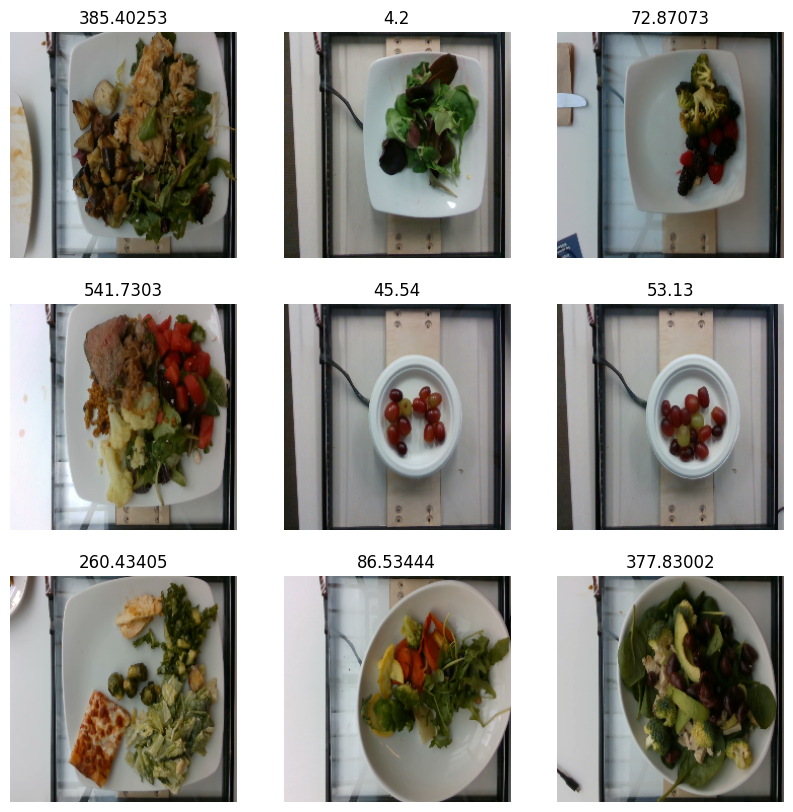

In [15]:
image_batch, label_batch = next(iter(train_data))

dask_mean = [123.97498, 119.645515, 111.2731]
dask_stdev = [56.1621, 59.680405, 66.39102]

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = image_batch[i].numpy()
  img = (img * dask_stdev) + dask_mean #undo dask normalization
  img = img.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
  img = img.astype(np.uint8)

  plt.imshow(img)
  label = label_batch[i]
  plt.title(label.numpy()[0]) #preview calories only
  plt.axis("off")

The above images with total calories at the title look like the data has been set-up correctly. Calories visually seem to make sense too. Note that we have other macro info, but are only displaying the calories for this preview.

**Next standardize the data in case missed in preprocessing pipeline**

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here we standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

### Build Base Transfer Learning Model (Before Fine Tuning)

In [16]:
MODEL_NAME = 'EfficientNetV2L_teacher_model'

def build_base_model(image_height, image_width, num_channels, num_classes):



  # Model input
  inputs = keras.Input(shape = (image_height, image_width, num_channels)) # height, width, channels

  IMAGE_HEIGHT = 224
  IMAGE_WIDTH = 224
  NUM_CHANNELS = 3
  batch_size = 128
  num_macros = 5


  base_model = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_tensor=None)
  # We make sure that the base_model is running in inference mode here,
  # by passing `training=False`. This is important for fine-tuning
  base_model.trainable = False

  inputs = keras.Input(shape = (image_height, image_width, num_channels))
  x = base_model(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)
  x = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=2121))(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)
  # x = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same",
  #                           kernel_initializer=keras.initializers.GlorotUniform(seed=2121))(x)
  # x = keras.layers.LeakyReLU(alpha=0.2)(x)
  # x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)
  x = keras.layers.Flatten()(x)
  #x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(units=4096, activation='relu')(x)
  x = keras.layers.Dense(units=4096, activation='relu')(x)
  x = keras.layers.Dense(units=4096, activation='relu')(x)
  # x = keras.layers.Dense(units=4096, activation='relu')(x)
  # A Dense layer, linear for multi-regression output
  outputs = keras.layers.Dense(units=num_classes)(x)
  model = keras.Model(inputs, outputs, name=MODEL_NAME)



  return model

### Train Base Model

In [17]:
# Login to W&B account
wandb.login()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [18]:
### Train Base Model

############################
# Training Params
############################
learning_rate = 0.001
initial_epoch = 0
epochs = 100
num_macros = 5


ES_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.1)


# Load pre trained model during demos
LOAD_PREV_TRAINED = False

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.MeanAbsoluteError()
# Metrics
metrics=[keras.metrics.RootMeanSquaredError()]
# Build or Load Model
if not LOAD_PREV_TRAINED:

  # Build the base model
  base_model = build_base_model(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, num_macros)
  print(base_model.summary())

  # folder in which to save initial, untrained model
  INIT_MODEL_DIR = "init_model_keras_EV2L_Teacher"

  # folder in which to save the final, trained model
  # if you want to train a sufficiently different model, give this a new name
  # to start a new lineage for the model, instead of just incrementing the
  # version of the old model
  FINAL_MODEL_DIR = "trained_keras_model_EV2L_Teacher"

  # Initialize a W&B run
  run = wandb.init(
      project = 'snap-nutrition',
      config = {
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "loss": loss,
        "optimizer": optimizer,
        "metrics": [keras.metrics.RootMeanSquaredError()],
        "model_name": base_model.name
      },
      name = base_model.name,
      job_type = "train"
  )
  cfg = wandb.config

  # Compile
  base_model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=metrics)

else:
  # Load model
  base_model = keras.models.load_model("snapnutrition_data_bucket/compression_workspace/EfficientV2L_models/model.hdf5", custom_objects={'KerasLayer':hub.KerasLayer})
  print(base_model.summary())


  with open("snapnutrition_data_bucket/compression_workspace/EfficientV2L_models/model_train_history.json") as json_file:
    prev_training_history = json.load(json_file)
  with open("snapnutrition_data_bucket/compression_workspace/EfficientV2L_models/model_model_metrics.json") as json_file:
    model_metrics = json.load(json_file)

  epochs = len(prev_training_history["loss"])
  initial_epoch=epochs
  epochs=epochs+1 # Continue training for a few more epochs

# log initial model before training
model_artifact = wandb.Artifact(
          "iv3", type="model",
          description="untrained teacher EfficientV2L",
          metadata=dict(cfg))

base_model.save(INIT_MODEL_DIR)
model_artifact.add_dir(INIT_MODEL_DIR)
run.log_artifact(model_artifact)

# Train model
start_time = time.time()
training_results = base_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        verbose=1, callbacks=[ES_callback, WandbCallback()])
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# save trained model as artifact
trained_model_artifact = wandb.Artifact(
          "Trained_Teacher", type="model",
          description="trained teacher",
          metadata=dict(cfg))

base_model.save(FINAL_MODEL_DIR)
trained_model_artifact.add_dir(FINAL_MODEL_DIR)
run.log_artifact(trained_model_artifact)
# Close the W&B run
wandb.run.finish()

# Get model training history
training_history = training_results.history

if LOAD_PREV_TRAINED:
  # Append previous training history & time
  training_history = append_training_history(training_results.history,
                                             prev_training_history,
                                             metrics=["loss","val_loss","root_mean_squared_error","val_root_mean_squared_error"])
  execution_time = model_metrics["execution_time"] + execution_time


473176280/473176280 [==============================] - 22s 0us/step
Model: "EfficientNetV2L_teacher_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-l (Function  (None, None, None, 1280   117746848 
 al)                         )                                   
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 1280)        0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 16)          184336    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2, 2, 16)          0         
                                   

wandb: Currently logged in as: wschristina (snap-nutrition). Use `wandb login --relogin` to force relogin


None


wandb: Adding directory to artifact (./init_model_keras_EV2L_Teacher)... Done. 1.8s
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
     18/Unknown - 110s 4s/step - loss: 72.7669 - root_mean_squared_error: 140.9123

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231027_153729-lfhhof07/files/model-best)... Done. 2.6s


18/18 [==============================] - 262s 13s/step - loss: 72.7669 - root_mean_squared_error: 140.9123 - val_loss: 67.1588 - val_root_mean_squared_error: 137.1516
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 65.3179 - root_mean_squared_error: 129.3291

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231027_153729-lfhhof07/files/model-best)... Done. 2.4s


18/18 [==============================] - 133s 8s/step - loss: 65.3179 - root_mean_squared_error: 129.3291 - val_loss: 62.6401 - val_root_mean_squared_error: 122.9558
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 63.2050 - root_mean_squared_error: 124.2510

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231027_153729-lfhhof07/files/model-best)... Done. 2.4s


18/18 [==============================] - 134s 8s/step - loss: 63.2050 - root_mean_squared_error: 124.2510 - val_loss: 59.4772 - val_root_mean_squared_error: 115.5704
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 62.5415 - root_mean_squared_error: 123.3707

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231027_153729-lfhhof07/files/model-best)... Done. 2.4s


18/18 [==============================] - 137s 8s/step - loss: 62.5415 - root_mean_squared_error: 123.3707 - val_loss: 57.6949 - val_root_mean_squared_error: 115.9373
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 58.0145 - root_mean_squared_error: 117.0295

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231027_153729-lfhhof07/files/model-best)... Done. 2.4s


18/18 [==============================] - 135s 8s/step - loss: 58.0145 - root_mean_squared_error: 117.0295 - val_loss: 50.9503 - val_root_mean_squared_error: 103.3743
Epoch 6/100
18/18 [==============================] - 6s 308ms/step - loss: 57.9881 - root_mean_squared_error: 118.3575 - val_loss: 57.2089 - val_root_mean_squared_error: 108.5555
Epoch 7/100
18/18 [==============================] - ETA: 0s - loss: 55.7338 - root_mean_squared_error: 113.5392

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231027_153729-lfhhof07/files/model-best)... Done. 4.3s


18/18 [==============================] - 135s 8s/step - loss: 55.7338 - root_mean_squared_error: 113.5392 - val_loss: 50.2072 - val_root_mean_squared_error: 102.1835
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 53.2302 - root_mean_squared_error: 110.3989

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231027_153729-lfhhof07/files/model-best)... Done. 2.7s


18/18 [==============================] - 135s 8s/step - loss: 53.2302 - root_mean_squared_error: 110.3989 - val_loss: 49.3160 - val_root_mean_squared_error: 100.3975
Epoch 9/100
18/18 [==============================] - ETA: 0s - loss: 51.7865 - root_mean_squared_error: 107.9881

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231027_153729-lfhhof07/files/model-best)... Done. 3.7s


18/18 [==============================] - 137s 8s/step - loss: 51.7865 - root_mean_squared_error: 107.9881 - val_loss: 47.0167 - val_root_mean_squared_error: 93.0614
Epoch 10/100
18/18 [==============================] - 9s 428ms/step - loss: 51.4943 - root_mean_squared_error: 107.8194 - val_loss: 48.5777 - val_root_mean_squared_error: 100.7466
Epoch 11/100
18/18 [==============================] - 5s 286ms/step - loss: 51.1161 - root_mean_squared_error: 107.1471 - val_loss: 50.0765 - val_root_mean_squared_error: 93.6774
Epoch 12/100
18/18 [==============================] - 5s 286ms/step - loss: 49.0891 - root_mean_squared_error: 103.5197 - val_loss: 48.6417 - val_root_mean_squared_error: 101.0535
Training execution time (mins) 20.586253742376964


wandb: Adding directory to artifact (./trained_keras_model_EV2L_Teacher)... Done. 4.8s


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▆▅▅▄▄▃▂▂▂▂▁
root_mean_squared_error,█▆▅▅▄▄▃▂▂▂▂▁
val_loss,█▆▅▅▂▅▂▂▁▂▂▂
val_root_mean_squared_error,█▆▅▅▃▃▂▂▁▂▁▂
best_epoch,8
best_val_loss,47.01669
epoch,11
loss,49.08909
root_mean_squared_error,103.51972
val_loss,48.64167


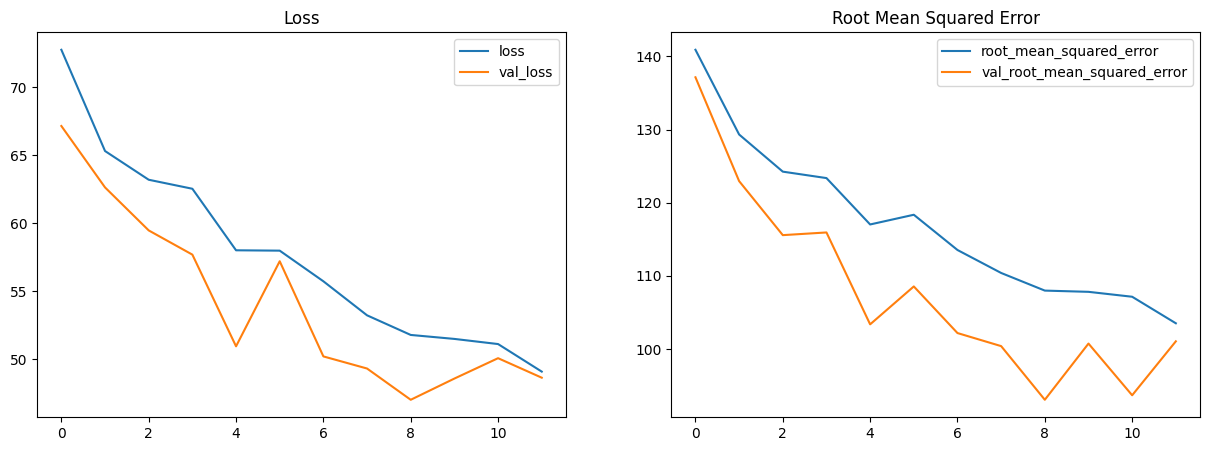

4/4 [==============================] - 3s 291ms/step - loss: 48.6417 - root_mean_squared_error: 101.0535
{'loss': 48.641666412353516, 'root_mean_squared_error': 101.05352020263672}
Inference execution time (mins) 0.0471672256787618


<ipython-input-12-b9749c9f4db7>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


Model before zip: 608055.45 Kb
Model after zip: 545842.41 Kb


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[48.641666412353516, 101.05352020263672]

In [19]:
# Evaluate model and Save
evaluate_model(base_model, validation_data, training_history, execution_time,
                    learning_rate, batch_size, epochs, optimizer,
                    save=True,
                    loss_metrics=["loss","val_loss"],
                    acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"])

In [20]:
training_history

{'loss': [72.76689147949219,
  65.31792449951172,
  63.204978942871094,
  62.541534423828125,
  58.014488220214844,
  57.988128662109375,
  55.73381423950195,
  53.23020935058594,
  51.78654479980469,
  51.494327545166016,
  51.11606979370117,
  49.089088439941406],
 'root_mean_squared_error': [140.91229248046875,
  129.3291473388672,
  124.25096893310547,
  123.37065887451172,
  117.02945709228516,
  118.35751342773438,
  113.5391845703125,
  110.39888763427734,
  107.98809814453125,
  107.81942749023438,
  107.14714813232422,
  103.51972198486328],
 'val_loss': [67.15880584716797,
  62.64014434814453,
  59.47718048095703,
  57.69488525390625,
  50.95029830932617,
  57.208892822265625,
  50.20724868774414,
  49.315975189208984,
  47.016693115234375,
  48.57767105102539,
  50.07646560668945,
  48.641666412353516],
 'val_root_mean_squared_error': [137.15164184570312,
  122.95577239990234,
  115.5704345703125,
  115.93727111816406,
  103.37425994873047,
  108.55545806884766,
  102.183471

In [21]:
full_test_predicted_base_model = base_model.predict(test_data)
full_test_predicted_base_model[:5]

4/4 [==============================] - 34s 5s/step


array([[235.04443   , 217.68404   ,  11.930408  ,  14.061075  ,
         13.8205385 ],
       [299.45947   , 274.11417   ,  15.157261  ,  17.09184   ,
         19.517242  ],
       [ 59.591404  ,  66.74382   ,   1.8415277 ,   6.0789866 ,
          0.45195797],
       [156.14986   , 147.68547   ,   7.703742  ,  10.10029   ,
          7.844191  ],
       [348.83997   , 317.88922   ,  17.597406  ,  19.542896  ,
         23.673122  ]], dtype=float32)

### Build Teacher Model (Fine Tuned)

#### **Teacher Model**

Use base model above for fine tuning as teacher model.

In [22]:
teacher_model = base_model

In [23]:
# ############################
# # Training Params
# ############################

# batch_size = 8
# learning_rate = 0.001 #KEEP SMALL FOR FINE TUNING!!
# initial_epoch = 0
# epochs = 2 #keep epochs low!!
# num_macros = 5

# # Load pre trained model during demos
# LOAD_PREV_TRAINED = False

# # Free up memory
# K.clear_session()

# # Optimizer
# optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# # Loss
# #loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss = keras.losses.MeanAbsoluteError()

# # Build or Load Model
# if not LOAD_PREV_TRAINED:
#   # Build the teacher model
#   base_model.trainable = True #Make base transfer model trainable
#   teacher_model = base_model
#   print(teacher_model.summary())

#   # Compile
#   teacher_model.compile(optimizer=optimizer,
#                       loss=loss,
#                       metrics=[keras.metrics.RootMeanSquaredError()])

# else:
#   # Load model
#   teacher_model = keras.models.load_model("distil_models/teacher_model.hdf5", custom_objects={'KerasLayer':hub.KerasLayer})
#   print(teacher_model.summary())


#   with open("distil_models/teacher_model_train_history.json") as json_file:
#     prev_training_history = json.load(json_file)
#   with open("distil_models/teacher_model_model_metrics.json") as json_file:
#     model_metrics = json.load(json_file)

#   epochs = len(prev_training_history["loss"])
#   initial_epoch=epochs
#   epochs=epochs+1 # Continue training for a few more epochs (maybe 1 more)


# # Train model
# start_time = time.time()
# training_results = teacher_model.fit(
#         train_data,
#         validation_data=validation_data,
#         epochs=epochs,
#         initial_epoch=initial_epoch,
#         verbose=1)
# execution_time = (time.time() - start_time)/60.0
# print("Training execution time (mins)", execution_time)

# # Get model training history
# training_history = training_results.history

# if LOAD_PREV_TRAINED:
#   # Append previous training history & time
#   training_history = append_training_history(training_results.history,
#                                              prev_training_history,
#                                              metrics=["loss","val_loss","root_mean_squared_errorr","val_root_mean_squared_error"])
#   execution_time = model_metrics["execution_time"] + execution_time

# # Evaluate model
# evaluate_model(teacher_model, validation_data, training_history, execution_time,
#                     learning_rate, batch_size, epochs, optimizer,
#                     save=True,
#                     loss_metrics=["loss","val_loss"],
#                     acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"])

In [24]:
full_test_predicted_teacher = teacher_model.predict(test_data)
full_test_predicted_teacher[:5]

4/4 [==============================] - 1s 332ms/step


array([[307.00864   , 280.30188   ,  15.557976  ,  17.33346   ,
         20.386305  ],
       [ 62.565598  ,  70.8081    ,   1.8787278 ,   6.482728  ,
          0.41438955],
       [186.96123   , 175.47383   ,   9.348224  ,  11.748619  ,
          9.969787  ],
       [ 74.84411   ,  78.246254  ,   2.8305223 ,   6.5001483 ,
          1.1027315 ],
       [281.64627   , 258.1414    ,  14.170335  ,  16.182535  ,
         18.288673  ]], dtype=float32)

#### **Student Model**

Student model is just 2 conv layers with max pooling and a dense layer

In [25]:
def build_student_model(image_height, image_width, num_channels, num_classes, model_name='student'):
  model_name = 'Student_Model'

  # Model input
  input_shape = [image_height, image_width, num_channels]  # height, width, channels

  model = Sequential(
      [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=1212)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=2121)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Flatten(),
        # keras.layers.Dense(units=32, kernel_initializer=keras.initializers.GlorotUniform(seed=2323)),
        keras.layers.Dense(units=num_classes, kernel_initializer=keras.initializers.GlorotUniform(seed=3434))
      ],
      name=model_name)

  return model

#### **Train Student from Scratch**

We do this for for comparison purposes

Model: "Student_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                

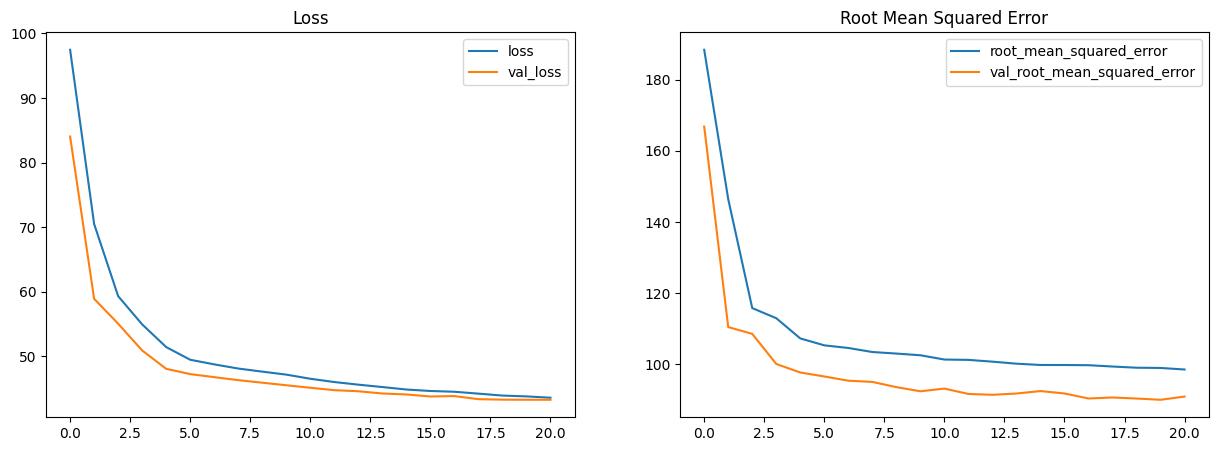

4/4 [==============================] - 0s 34ms/step - loss: 43.2364 - root_mean_squared_error: 90.9955
{'loss': 43.23638916015625, 'root_mean_squared_error': 90.99551391601562}
Inference execution time (mins) 0.0034422834714253744
Model before zip: 89.82 Kb
Model after zip: 66.30 Kb


<ipython-input-12-b9749c9f4db7>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


[43.23638916015625, 90.99551391601562]

In [26]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 50
ES_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.1)


# Free up memory
K.clear_session()

# Build the model
student_model_scratch = build_student_model(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, num_macros, model_name='student_scratch')
print(student_model_scratch.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.MeanAbsoluteError()
# Compile
student_model_scratch.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.RootMeanSquaredError()])

# Train teacher model
start_time = time.time()
training_results = student_model_scratch.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[ES_callback],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluate_model(student_model_scratch,validation_data, training_history,execution_time,
                    learning_rate, batch_size, epochs, optimizer,
                    save=True,
                    loss_metrics=["loss","val_loss"],
                    acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"])


In [27]:
full_test_predicted_scratch_student = student_model_scratch.predict(test_data)
full_test_predicted_scratch_student[:5]

4/4 [==============================] - 0s 36ms/step


array([[120.699135 ,  71.40312  ,   8.48551  ,  11.733926 ,   8.213437 ],
       [ -5.867572 ,   9.105791 ,  -2.7660499,   2.599098 ,  -1.7504807],
       [466.1409   , 353.3703   ,  17.48349  ,  28.594534 ,  28.452522 ],
       [200.65076  , 163.26971  ,   3.9520237,  14.340707 ,   4.021233 ],
       [191.5554   , 168.26703  ,   9.068634 ,  16.04402  ,  18.988766 ]],
      dtype=float32)

## **<font color="#324bd9">Build Distiller</font>**

In [28]:
class Distiller(Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, Lambda = 0.1, temperature=3):
      """
      optimizer: Keras optimizer for the student weights
      metrics: Keras metrics for evaluation
      student_loss_fn: Loss function of difference between student predictions and ground-truth
      distillation_loss_fn: Loss function of difference between soft student predictions and soft teacher predictions
      lambda: weight to student_loss_fn and 1-alpha to distillation_loss_fn
      temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn

      #hyper-parameters
      self.Lambda = Lambda
      self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher (professor)
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.Lambda * student_loss + (1 - self.Lambda) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

## **<font color="#324bd9">Distill Teacher to Student</font>**

Model: "Student_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                

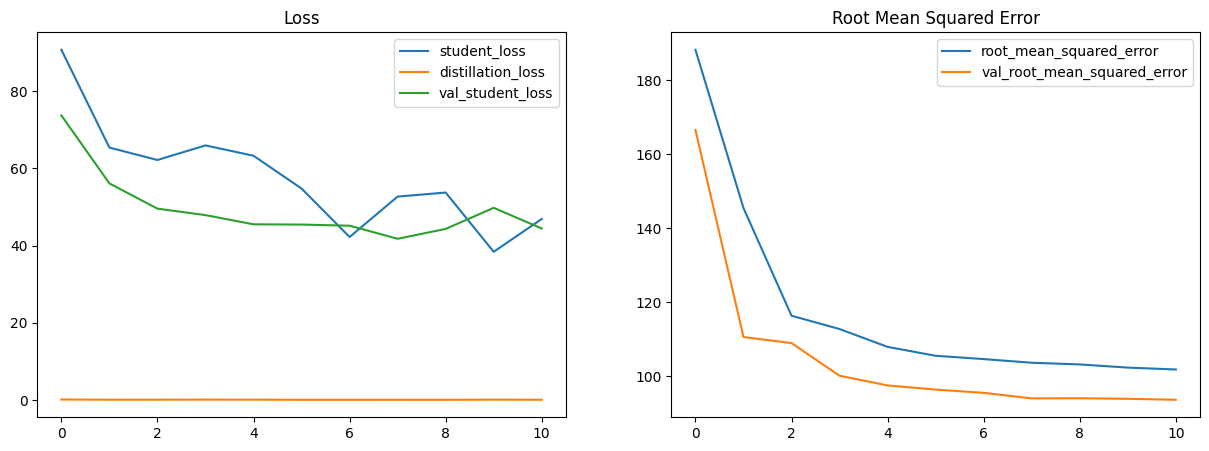

4/4 [==============================] - 0s 36ms/step - root_mean_squared_error: 93.5563 - student_loss: 45.0286
{'root_mean_squared_error': 93.5562973022461, 'student_loss': 44.413761138916016}
Inference execution time (mins) 0.0034277915954589845


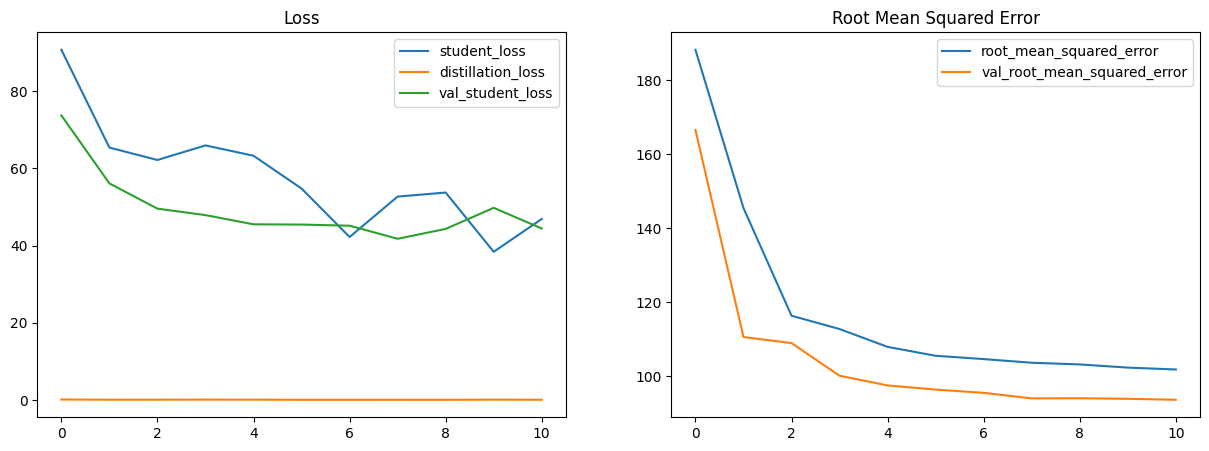

4/4 [==============================] - 0s 34ms/step - loss: 45.2185 - root_mean_squared_error: 93.5563
{'loss': 45.21851348876953, 'root_mean_squared_error': 93.5562973022461}
Inference execution time (mins) 0.0047888596852620445
Model before zip: 89.82 Kb
Model after zip: 66.15 Kb


<ipython-input-12-b9749c9f4db7>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


[44.413761138916016, 93.5562973022461]

In [29]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 15 #optimal found to be 15 in one run
Lambda = 0.75
temperature= 12

ES_callback = tf.keras.callbacks.EarlyStopping(monitor='val_student_loss', patience=3, min_delta=0.1)


# Free up memory
K.clear_session()

# Build Student model
student_model = build_student_model(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, num_macros, model_name='student_distill')
print(student_model.summary())

# Build the distiller model
distiller_model = Distiller(teacher=teacher_model, student=student_model)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
student_loss = keras.losses.MeanAbsoluteError()
#distillation_loss = keras.losses.KLDivergence()
distillation_loss = keras.losses.MeanAbsoluteError()

# Compile
distiller_model.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    metrics=[keras.metrics.RootMeanSquaredError()],
    Lambda=Lambda,
    temperature=temperature
)

# Distill teacher to student
start_time = time.time()
training_results = distiller_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[ES_callback],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluation_results = evaluate_model(distiller_model,validation_data,
               training_history,execution_time,learning_rate, batch_size, epochs, optimizer,
               save=False,
               loss_metrics=["student_loss","distillation_loss","val_student_loss"],
               acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"])

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.MeanAbsoluteError()
# Compile
student_model_scratch.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.RootMeanSquaredError()])
# Compile
student_model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.RootMeanSquaredError()]
)


# Save student model
#save_model(student_model,training_history,execution_time,learning_rate, epochs, optimizer, evaluation_results)
evaluate_model(student_model, validation_data,
               training_history,execution_time,learning_rate, batch_size, epochs, optimizer,
               save=True,
               loss_metrics=["student_loss","distillation_loss","val_student_loss"],
               acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"], evaluation_metrics=evaluation_results)

In [30]:
#Run for just a few more epochs to save into WB

epochs = 1 #limit 1 just for tracking by WB

# folder in which to save initial, untrained model
INIT_MODEL_DIR = "init_model_keras_EV2L_Student"

# folder in which to save the final, trained model
# if you want to train a sufficiently different model, give this a new name
# to start a new lineage for the model, instead of just incrementing the
# version of the old model
FINAL_MODEL_DIR = "distilled_keras_model_EV2L_Student"

# Initialize a W&B run
run = wandb.init(
    project = 'snap-nutrition',
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "loss": loss,
      "optimizer": optimizer,
      "metrics": [keras.metrics.RootMeanSquaredError()],
      "model_name": student_model.name
    },
    name = student_model.name,
    job_type = "train"
)
cfg = wandb.config

# log initial model before training
model_artifact = wandb.Artifact(
          "student_distilled", type="model",
          description="student distilled EfficientV2L",
          metadata=dict(cfg))

student_model.save(INIT_MODEL_DIR)
model_artifact.add_dir(INIT_MODEL_DIR)
run.log_artifact(model_artifact)

# Train model
start_time = time.time()
training_results = student_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        verbose=1, callbacks=[WandbCallback()])
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

 # save trained model as artifact
trained_model_artifact = wandb.Artifact(
          "distilled_student", type="model",
          description="distilled student plus 1 more epoch",
          metadata=dict(cfg))

student_model.save(FINAL_MODEL_DIR)
trained_model_artifact.add_dir(FINAL_MODEL_DIR)
run.log_artifact(trained_model_artifact)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

wandb: Adding directory to artifact (./init_model_keras_EV2L_Student)... Done. 0.0s


     17/Unknown - 2s 28ms/step - loss: 46.2778 - root_mean_squared_error: 102.0101

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231027_161148-tfce166f/files/model-best)... Done. 0.0s


18/18 [==============================] - 3s 109ms/step - loss: 46.1791 - root_mean_squared_error: 101.2502 - val_loss: 44.8067 - val_root_mean_squared_error: 93.0216
Training execution time (mins) 0.05455019474029541


wandb: Adding directory to artifact (./distilled_keras_model_EV2L_Student)... Done. 0.0s


epoch,▁
loss,▁
root_mean_squared_error,▁
val_loss,▁
val_root_mean_squared_error,▁
best_epoch,0
best_val_loss,44.80675
epoch,0
loss,46.17913
root_mean_squared_error,101.25018
val_loss,44.80675


## **<font color="#324bd9">Compare All Models</font>**

In [31]:
models_folder = experiment_name
#models_folder = "models" # distil_models / models
models_metrics_list = glob(models_folder+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(models_folder+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

view_metrics.head()

,trainable_parameters,execution_time,loss,root_mean_squared_error,model_size,learning_rate,batch_size,epochs,optimizer,before_zip_size,after_zip_size,test_set_inference_time(min),name
0,33837077,20.586254,48.641666,101.053520,878773736,0.001,128,100,Adam,608055.448,545842.410,0.047167,EfficientNetV2L_teacher_model
1,17077,1.060080,44.413761,93.556297,95424,0.001,128,15,Adam,89.816,66.146,0.004789,Student_Model
2,17077,0.195201,43.185097,90.293259,246216,0.001,128,5,Adam,89.816,66.266,0.004611,after_prune
3,33839397,7.647051,46.847282,89.925156,878808864,0.100,128,24,Adam,608070.760,545952.613,0.095611,model
4,17077,6.409458,47.262486,92.287125,95424,0.001,128,14,Adam,89.816,66.190,0.005176,student_distill


## **<font color="#324bd9">TFLite Quantization</font>**

https://www.tensorflow.org/lite/performance/post_training_quantization

Dynamic range quantization is a recommended starting point because it provides reduced memory usage and faster computation without you having to provide a representative dataset for calibration. This type of quantization, statically quantizes only the weights from floating point to integer at conversion time, which provides 8-bits of precision.

To further reduce latency during inference, "dynamic-range" operators dynamically quantize activations based on their range to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inferences. However, the outputs are still stored using floating point so the increased speed of dynamic-range ops is less than a full fixed-point computation.

In [32]:
#Without quantization

saved_model_dir = "./snapnutrition_data_bucket/compression_workspace_v2/distill_model"
student_model.save(saved_model_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
#saving converted model in "converted_model.tflite" file
open("./snapnutrition_data_bucket/compression_workspace_v2/distill_model/wo_quant_converted_model.tflite", "wb").write(tflite_model)

71436

In [33]:
# With quantization

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open("snapnutrition_data_bucket/compression_workspace_v2/distill_model/converted_quant_model.tflite", "wb").write(tflite_quant_model)

21248

In [34]:
import os
print("Float model in Mb:", os.path.getsize('./snapnutrition_data_bucket/compression_workspace_v2/distill_model/wo_quant_converted_model.tflite') / float(2**20))
print("Quantized model in Mb:", os.path.getsize('./snapnutrition_data_bucket/compression_workspace_v2/distill_model/converted_quant_model.tflite') / float(2**20))
print("Compression ratio:", os.path.getsize('./snapnutrition_data_bucket/compression_workspace_v2/distill_model/wo_quant_converted_model.tflite')/os.path.getsize('./snapnutrition_data_bucket/compression_workspace_v2/distill_model/converted_quant_model.tflite'))

Float model in Mb: 0.06812667846679688
Quantized model in Mb: 0.020263671875
Compression ratio: 3.3620105421686746


Evaluate the reduction in size of the model. (Notice, it is approximately 3.5x)

In [35]:
import os
print("Float model in Mb:", os.path.getsize('./snapnutrition_data_bucket/compression_workspace_v2/distill_model/wo_quant_converted_model.tflite') / float(2**20))
print("Quantized model in Mb:", os.path.getsize('./snapnutrition_data_bucket/compression_workspace_v2/distill_model/converted_quant_model.tflite') / float(2**20))
print("Compression ratio:", os.path.getsize('./snapnutrition_data_bucket/compression_workspace_v2/distill_model/wo_quant_converted_model.tflite')/os.path.getsize('./snapnutrition_data_bucket/compression_workspace_v2/distill_model/converted_quant_model.tflite'))

Float model in Mb: 0.06812667846679688
Quantized model in Mb: 0.020263671875
Compression ratio: 3.3620105421686746


https://medium.com/@sonalimedani/post-training-quantization-with-tensorflow-lite-on-a-keras-model-f373068966c4


https://stackoverflow.com/questions/50764572/how-can-i-test-a-tflite-model-to-prove-that-it-behaves-as-the-original-model-us

In [36]:
#Eval NON QUANT Model inference time on dummy data

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./snapnutrition_data_bucket/compression_workspace_v2/distill_model/wo_quant_converted_model.tflite")
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
start_time = time.time()
output_data = interpreter.get_tensor(output_details[0]['index'])
#get in seconds
reg_inference_time = (time.time() - start_time) #/60.0 for minutes
print("Distill Model Inference execution time (seconds)", reg_inference_time)
print(output_data)

Distill Model Inference execution time (seconds) 0.00011086463928222656
[[44.46361   40.237816   0.7827596  3.7914293  2.5139616]]


In [37]:
# Evaluate Quant Model inference time on dummy data size of test

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./snapnutrition_data_bucket/compression_workspace_v2/distill_model/converted_quant_model.tflite")
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
start_time = time.time()
output_data = interpreter.get_tensor(output_details[0]['index'])
#get in seconds
quant_inference_time = (time.time() - start_time) #/60.0 for minutes
print("Quant Model Inference execution time (seconds)", quant_inference_time)
print(output_data)

Quant Model Inference execution time (seconds) 0.00011181831359863281
[[44.455963  40.21952    0.781913   3.8070366  2.507856 ]]


In [38]:
inference_ratio = reg_inference_time/quant_inference_time
inference_ratio

0.9914712153518124

In [39]:
view_metrics.to_csv("./snapnutrition_data_bucket/compression_workspace_v2/view_metrics.csv")

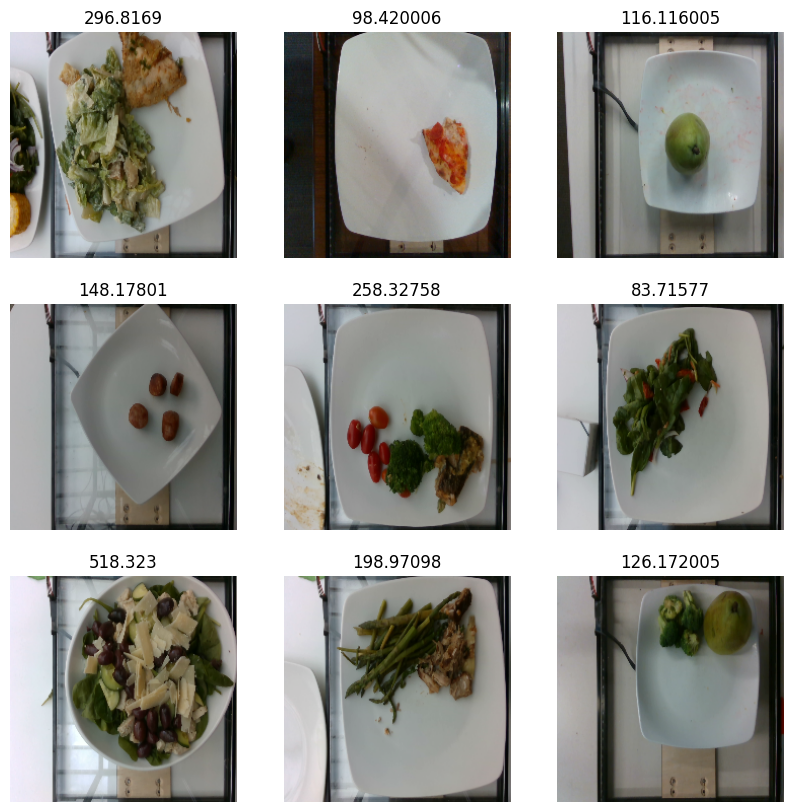

In [40]:
image_batch, label_batch = next(iter(train_data))

dask_mean = [123.97498, 119.645515, 111.2731]
dask_stdev = [56.1621, 59.680405, 66.39102]

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = image_batch[i].numpy()
  img = (img * dask_stdev) + dask_mean #undo dask normalization
  img = img.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
  img = img.astype(np.uint8)

  plt.imshow(img)
  label = label_batch[i]
  plt.title(label.numpy()[0]) #preview calories only
  plt.axis("off")

4/4 [==============================] - 0s 15ms/step


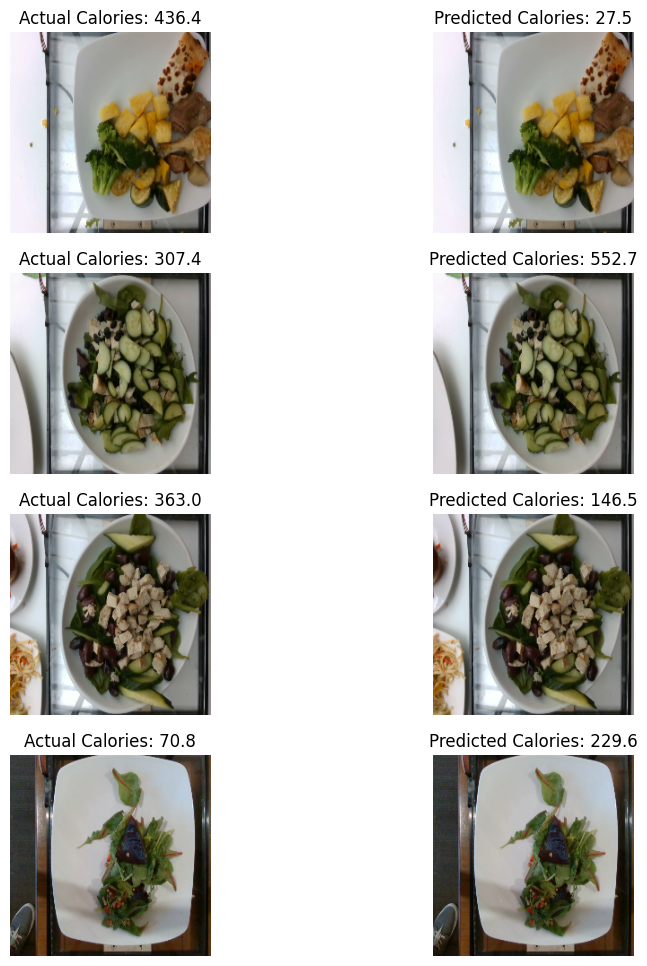

In [41]:
#Make Prediction

model = student_model

dask_mean = [123.97498, 119.645515, 111.2731]
dask_stdev = [56.1621, 59.680405, 66.39102]

#Test: show sample breakdown of actual v.s. predicted
fig, axs = plt.subplots(4, 2, figsize=(10, 12))
for ax in axs.ravel():
    ax.axis('off')

#(total_calories, total_mass, total_fat, total_carb, total_protein)
test_images = test_data.take(5)

actual_calories = []
actual_mass = []
actual_fat = []
actual_carb = []
actual_protein = []

pred_calories = []
pred_mass = []
pred_fat = []
pred_carb = []
pred_protein = []

for i, element in enumerate(test_images):
  #actual calories
  img = element[0][0].numpy()
  img = (img * dask_stdev) + dask_mean #undo dask normalization
  img = img.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
  img = img.astype(np.uint8)
  axs[i][0].imshow(img)
  axs[i][0].set_title(f'Actual Calories: {element[1][0][0]:.1f}')
  actual_calories.append(float(element[1][0][0]))
  actual_mass.append(float(element[1][0][1]))
  actual_fat.append(float(element[1][0][2]))
  actual_carb.append(float(element[1][0][3]))
  actual_protein.append(float(element[1][0][4]))



  predicted_macros = model.predict(element[0])
  predicted_calories = predicted_macros[1][0]
  img = element[0][0].numpy()
  img = (img * dask_stdev) + dask_mean #undo dask normalization
  img = img.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
  img = img.astype(np.uint8)
  axs[i][1].imshow(img)
  axs[i][1].set_title(f'Predicted Calories: {predicted_calories:.1f}')
  pred_calories.append(predicted_macros[1][0])
  pred_mass.append(predicted_macros[1][1])
  pred_fat.append(predicted_macros[1][2])
  pred_carb.append(predicted_macros[1][3])
  pred_protein.append(predicted_macros[1][4])

## **<font color="#324bd9">Pruning</font>**

We can compress a model by model pruning. Pruning is where we set the weights of a network connection to zero for those which have a very small value. This can help reduce the size of the model

#### **Analyze Model Weights**

Check how many weigths are zero. Usually most weights in a network have a very small values but are not zero.

In [42]:
def check_model_weights(model):
  for i, w in enumerate(model.get_weights()):
    print(model.weights[i].name,"Total:",w.size, "Zeros:", round(np.sum(np.abs(w) <= 0.0001) / w.size * 100,6),"%")

#check_model_weights(before_prune)
check_model_weights(student_model)

conv2d/kernel:0 Total: 216 Zeros: 0.0 %
conv2d/bias:0 Total: 8 Zeros: 0.0 %
conv2d_1/kernel:0 Total: 1152 Zeros: 0.173611 %
conv2d_1/bias:0 Total: 16 Zeros: 0.0 %
dense/kernel:0 Total: 15680 Zeros: 0.178571 %
dense/bias:0 Total: 5 Zeros: 0.0 %


#### **Model Size on Disk**

A simple way to ship models is to `zip` the model file. If we `zip` the model before pruning we see that there is not much difference.

In [43]:
def compare_model_sizes(model):
  _, model_file = tempfile.mkstemp(".h5")
  tf.keras.models.save_model(model, model_file, include_optimizer=False)
  # Zip the .h5 model file
  _, zip3 = tempfile.mkstemp(".zip")
  with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
      f.write(model_file)
  model_before_zip = os.path.getsize(model_file) / float(1000)
  model_after_zip = os.path.getsize(zip3) / float(1000)
  print("Model before zip: %.2f Kb"% model_before_zip)
  print("Model after zip: %.2f Kb"% model_after_zip)
  return model_before_zip, model_after_zip

In [44]:
#model_before_zip, model_after_zip = compare_model_sizes(before_prune)
model_before_zip, model_after_zip = compare_model_sizes(student_model)

Model before zip: 89.82 Kb
Model after zip: 66.17 Kb


<ipython-input-43-9ea667a9bd7d>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


In [45]:
#Compare performance
models_folder = experiment_name
#models_folder = "models" # distil_models / models
models_metrics_list = glob(models_folder+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(models_folder+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

view_metrics.head()

,trainable_parameters,execution_time,loss,root_mean_squared_error,model_size,learning_rate,batch_size,epochs,optimizer,before_zip_size,after_zip_size,test_set_inference_time(min),name
0,33837077,20.586254,48.641666,101.053520,878773736,0.001,128,100,Adam,608055.448,545842.410,0.047167,EfficientNetV2L_teacher_model
1,17077,1.060080,44.413761,93.556297,95424,0.001,128,15,Adam,89.816,66.146,0.004789,Student_Model
2,17077,0.195201,43.185097,90.293259,246216,0.001,128,5,Adam,89.816,66.266,0.004611,after_prune
3,33839397,7.647051,46.847282,89.925156,878808864,0.100,128,24,Adam,608070.760,545952.613,0.095611,model
4,17077,6.409458,47.262486,92.287125,95424,0.001,128,14,Adam,89.816,66.190,0.005176,student_distill


#### **Prune Model**

Now we use the tf optimization library to prune our model

In [46]:
# paths to read train test val data (has image filepaths and corresponding labels
TRAIN_SAVE_PATH = "./snapnutrition_data_bucket/data/processed_labels/train_data.pickle"

# read train, test, validation data from pickle files
train_xy = pd.read_pickle(TRAIN_SAVE_PATH)

len(train_xy)

2282

In [47]:
# Define model for pruning
epochs = 5
end_step = np.ceil(len(train_xy) / batch_size).astype(np.int32) * epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}
#model_for_pruning = prune_low_magnitude(before_prune, **pruning_params)
model_for_pruning = prune_low_magnitude(student_model, **pruning_params)
model_for_pruning._name = "after_prune"

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.MeanAbsoluteError()
model_for_pruning.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.RootMeanSquaredError()])

model_for_pruning.summary()

# Callback
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

# Train
start_time = time.time()
training_results = model_for_pruning.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Model: "after_prune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 112, 112, 8)       442       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_leaky_  (None, 112, 112, 8)       1         
 re_lu (PruneLowMagnitude)                                       
                                                                 
 prune_low_magnitude_max_po  (None, 56, 56, 8)         1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, 28, 28, 16)        2322      
 _1 (PruneLowMagnitude)                                          
                                                       

#### **Analyze Pruned Weights**

In [48]:
# Get the model back after pruning
after_prune = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
after_prune.summary()

check_model_weights(after_prune)

Model: "after_prune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                  

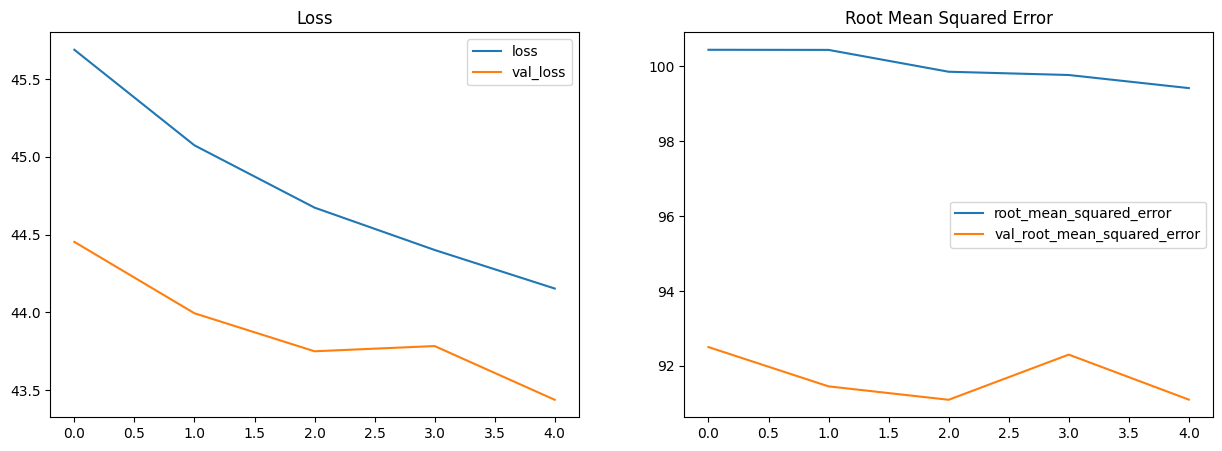

4/4 [==============================] - 0s 40ms/step - loss: 43.4383 - root_mean_squared_error: 91.1001
{'loss': 43.43827819824219, 'root_mean_squared_error': 91.10009765625}
Inference execution time (mins) 0.005141003926595052
Model before zip: 89.82 Kb
Model after zip: 66.27 Kb


<ipython-input-43-9ea667a9bd7d>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[43.43827819824219, 91.10009765625]

In [49]:
# Get model training history
training_history = training_results.history

# Compile
after_prune.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.RootMeanSquaredError()])

# Evaluate model
evaluate_model(after_prune, validation_data, training_history, execution_time,
               learning_rate, batch_size, epochs, optimizer,
               save=True,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"])

#### **Model Size on Disk after Pruning**

Now if we `zip` our model after pruning we see a significant reduction in size.

In [50]:
compare_model_sizes(after_prune)

Model before zip: 89.82 Kb
Model after zip: 66.27 Kb


<ipython-input-43-9ea667a9bd7d>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


(89.816, 66.273)

In [51]:
#Compare performance
models_folder = experiment_name
#models_folder = "models" # distil_models / models
models_metrics_list = glob(models_folder+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(models_folder+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

view_metrics.head()

,trainable_parameters,execution_time,loss,root_mean_squared_error,model_size,learning_rate,batch_size,epochs,optimizer,before_zip_size,after_zip_size,test_set_inference_time(min),name
0,33837077,20.586254,48.641666,101.053520,878773736,0.001,128,100,Adam,608055.448,545842.410,0.047167,EfficientNetV2L_teacher_model
1,17077,1.060080,44.413761,93.556297,95424,0.001,128,15,Adam,89.816,66.146,0.004789,Student_Model
2,17077,0.186013,43.438278,91.100098,246216,0.001,128,5,Adam,89.816,66.273,0.005141,after_prune
3,33839397,7.647051,46.847282,89.925156,878808864,0.100,128,24,Adam,608070.760,545952.613,0.095611,model
4,17077,6.409458,47.262486,92.287125,95424,0.001,128,14,Adam,89.816,66.190,0.005176,student_distill


In [52]:
get_model_size("after_prune")

246216